In [1]:
import numpy as np
import random
from platypus import Hypervolume, display, calculate, CMAES, MOEAD, NSGAII, NSGAIII, SPEA2, IBEA, Problem, Real
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

from datetime import datetime

In [2]:
from load_data import *
from bias_functions import *
from utility_functions import *

In [88]:
def getDataset(setSelection):
    if setSelection == 'toy':
        X,y = generate_toy_data(1000,200,2)
    elif setSelection == 'adult':
        protectedAttributes={'race':'White','gender':'Male'}
        X,y = load_adult(protectedAttributes=protectedAttributes)
    elif setSelection == 'bank':
        X,y = load_bank()
    elif setSelection == 'german':
        X,y = load_german()
    elif setSelection == 'mortgage':
        protectedCategoricalAttributes={'applicant_ethnicity_name':'Not Hispanic or Latino',
                                'applicant_race_name_1':'White','applicant_sex_name':'Male'}
        protectedNumericalAttributes=['minority_population']
        X,y = load_mortgage(protectedCategoricalAttributes=protectedCategoricalAttributes, \
                            protectedNumericalAttributes=protectedNumericalAttributes)
    else:
        print('dataset not recognised')
        
    X = np.hstack([X, np.ones((X.shape[0],1))]) ## add ones to solve for affine functions
    
    return X,y

In [38]:
# existing problems

# problem 2 with business necessity: zafar, bank dataset, sensistive attribute = age (0), train/test = 0.7/0.3
# objectives: accuracy, DI, business necessity

def problem2businessNecessity_base(w,X,y,sensitiveAttributeIndex):
    errorRateObjective = errorRate(w,X,y)
    fairnessObjective= differenceDisparateImpactModel(w,X,sensitiveAttributeIndex=sensitiveAttributeIndex)
    businessConstraint = businessNecessityConstraint(w,trainxs,trainys,unconstrainedLoss,gamma)
    
    if str(type(businessConstraint))=="<class 'numpy.float64'>":
        businessConstraint = [businessConstraint, ]
    return [errorRateObjective, np.abs(fairnessObjective[0]-fairnessObjective[1])], businessConstraint

def problem2businessNecessity_train(w):
    return problem2businessNecessity_base(w,trainxs,trainys,sensitiveAttributeIndex=0)
def problem2businessNecessity_test(w):
    return problem2businessNecessity_base(w,testxs,testys,sensitiveAttributeIndex=0)

## Sensitive attributes list:

adult: 8 - race, 9 - gender ;  variables = 15 ; 45222 samples

bank: 0 - age ; variables = 21 ; 41188 samples

german: 6 - gender, 9 - age, 14 - race ; variables = 25 ; 1000 samples

mortgage: 12 - ethnicity, 14 - race, 16 - gender, 24 - minority population ; variables = 30 ; 200000 samples

In [120]:
now = datetime.now()

# these lines define the problem, test problem, dataset, algorithm and number of sampling runs
noOfVariables = 21
noOfObjectives = 2

problem = Problem(noOfVariables,noOfObjectives,32950)
problem.function = problem2businessNecessity_train

testProblem = Problem(noOfVariables,noOfObjectives)
testProblem.function = problem2businessNecessity_test

businessNecessityProblem = True
dataset = 'bank'

trainAlgorithm = NSGAII(problem)

noOfSamplingRuns = 1

X,y = getDataset(dataset)

problem.types[:] = Real(-5,5)
problem.constraints[:] = "<=0"

hypervolumeArray = np.zeros((noOfSamplingRuns, 2)) # col 0 for training results (hypervolume), col 1 for test results
extremesArray = np.zeros((2, noOfObjectives, noOfObjectives, noOfSamplingRuns)) # the first dimension is for train/test
averagePointArray = np.zeros((2, noOfSamplingRuns, noOfObjectives)) # the first dimension is for train/test. This array holds the average objective point for each run

# these will be used to store the algorithm that returns the largest hypervolume
bestTrainAlgorithm = None
bestTrainHypervolume = 0
bestTestAlgorithm = None
bestTestHypervolume = 0
totalTrainTime = 0
totalTestTime = 0

for run in range(noOfSamplingRuns):

    # generate new train/test split for each run
    trainxs, testxs, trainys, testys  = train_test_split(X,y,train_size=0.8)
    
    
    # training run
    startTime = time.perf_counter()
    
    if businessNecessityProblem:
        unconstrainedLoss = computeUnconstrainedLoss(trainxs,trainys,trainxs,trainys, returnIndividualLosses=True)
        gammaMultiplier = 10
        
        if str(type(unconstrainedLoss))=="<class 'numpy.float64'>":
            gamma = gammaMultiplier
            numberOfConstraints = 1
        else:
            gamma = gammaMultiplier * np.ones(len(unconstrainedLoss))
            numberOfConstraints = len(gamma)

    trainAlgorithm.run(10000)

    trainHyp = Hypervolume(minimum=[0]*noOfObjectives,maximum=[1]*noOfObjectives)
    trainHypResult = trainHyp(trainAlgorithm.result)  
    hypervolumeArray[run, 0] = trainHypResult
    
    singleRunExtremesArray, averagePoint = findExtremes_averagePoint(trainAlgorithm)
    extremesArray[0,:,:,run] = singleRunExtremesArray
    averagePointArray[0,run,:] = averagePoint
    
    endTime = time.perf_counter()
    trainTime = endTime - startTime
    totalTrainTime += trainTime
    
    print("{}: training took {:.2f} seconds w/ hypervolume {:2f}".format(run, trainTime, trainHypResult))
    
    
    # test run
    testAlgorithm = deepcopy(trainAlgorithm)

    startTime = time.perf_counter()

    for resultNumber, result in enumerate(testAlgorithm.result):

        w=result.variables
        objectivesResult = testProblem.function(w)

        # copy objective results individually to the testAlgorithm object
        for i in range(len(objectivesResult)):  
            testAlgorithm.result[resultNumber].objectives[i]=objectivesResult[i]
      
    endTime = time.perf_counter()
    testTime = endTime - startTime
    totalTestTime += testTime

    print("{}: testing took {:.2f} seconds w/ hypervolume {:2f}".format(run, testTime, testHypResult))
    
    if trainHypResult > bestTrainHypervolume:
        bestTrainHypervolume = trainHypResult
        bestTrainAlgorithm = deepcopy(trainAlgorithm)
        
        bestTestHypervolume = testHypResult
        bestTestAlgorithm = deepcopy(testAlgorithm)
        
        bestData = [trainxs, testxs, trainys, testys]
        bestDataSavePath = "saved_data/"+now.strftime("%Y%m%d_%H%M")+"_"+str(problem.function)[10:18]+"_"+dataset+"_"+str(trainAlgorithm)[21:-26]+"_data"
        np.save(bestDataSavePath, bestData)
        

# resultsSummary:
# column 0: average hypervolume, column 1: hypervolume std, column 2: average point std (Euclidean distance), column 3: average time
# row 0: training data, row 1: test data
resultsSummary = np.zeros((2,4)) 
resultsMean = np.sum(hypervolumeArray, axis=0)/noOfSamplingRuns 
resultsSummary[:,0] = resultsMean
resultsSummary[:,1] = np.sqrt(np.sum((hypervolumeArray - resultsMean)**2, axis=0)/noOfSamplingRuns)
averagePointMeans = np.mean(averagePointArray,axis=1)
resultsSummary[0,2] = np.std(np.sqrt(np.sum((averagePointArray[0,:,:]-averagePointMeans[0,:])**2,axis=1)))
resultsSummary[1,2] = np.std(np.sqrt(np.sum((averagePointArray[1,:,:]-averagePointMeans[1,:])**2,axis=1)))
resultsSummary[0,3] = totalTrainTime/noOfSamplingRuns
resultsSummary[1,3] = totalTestTime/noOfSamplingRuns
resultsSummary

(41188, 21)
(41188, 20)
age: 0
The dataset is loaded...
0: training took 2042.05 seconds w/ hypervolume 0.801557


TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [123]:
bestTrainAlgorithm = trainAlgorithm

## Plot the results with the largest hypervolume during training

(0.0, 0.16)

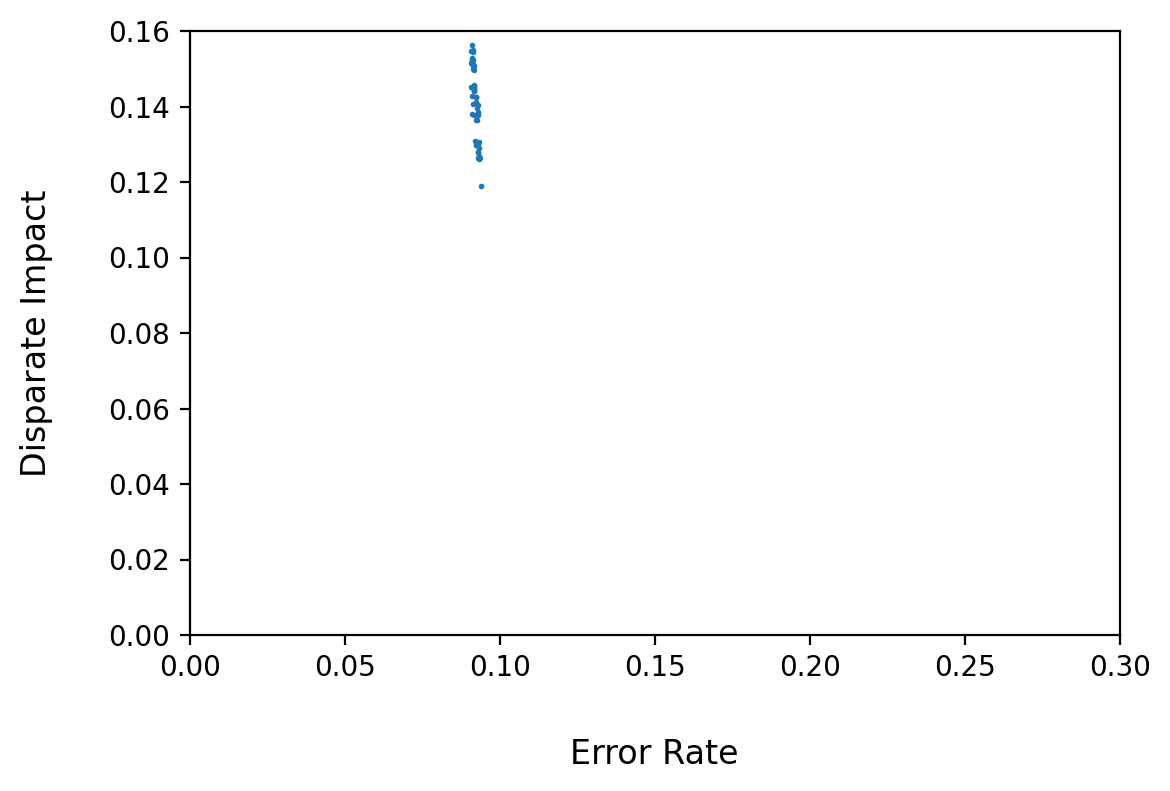

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt

now = datetime.now()

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter([s.objectives[0] for s in bestTrainAlgorithm.result],
           [s.objectives[1] for s in bestTrainAlgorithm.result],s=1)
ax.set_xlabel("Error Rate",labelpad=20,size=12)
ax.set_ylabel("Disparate Impact",labelpad=20,size=12)
ax.set_xlim([0.0,0.3])
ax.set_ylim([0,0.16])

# plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+str(problem.function)[10:-19]+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_graph",bbox_inches = 'tight')

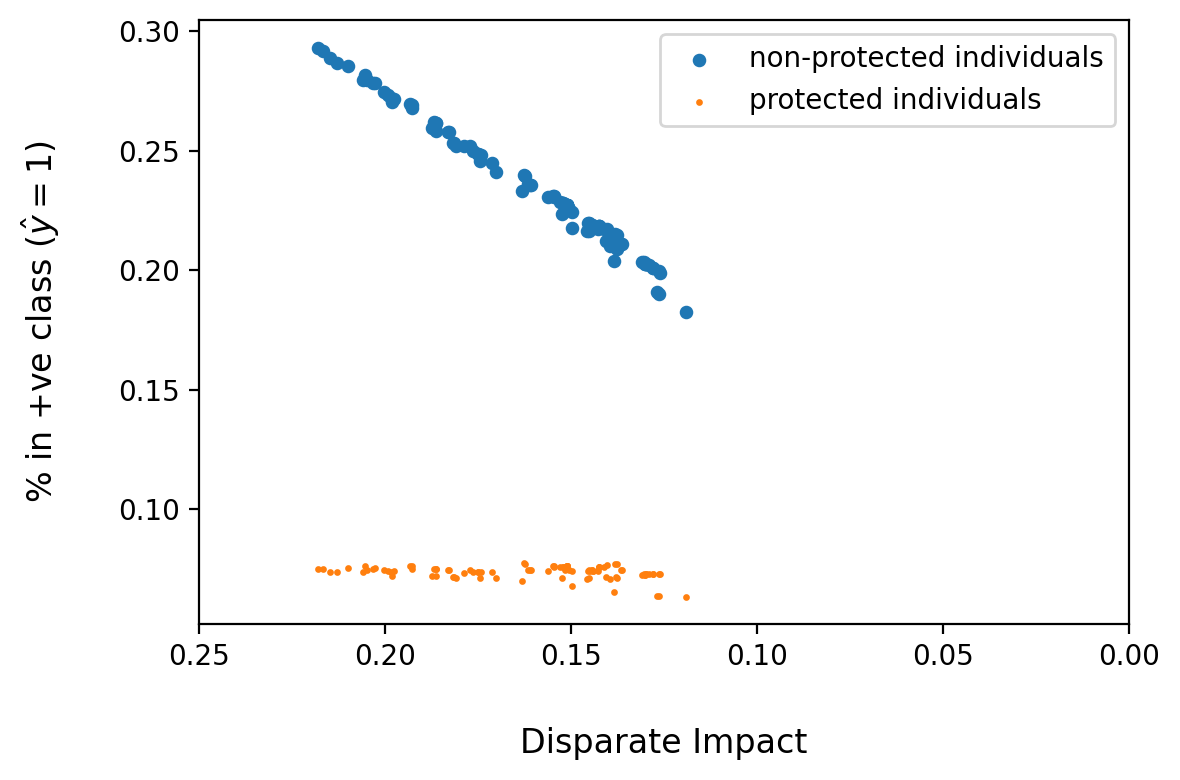

In [128]:
DIarray = returnDIlist(bestTrainAlgorithm, trainxs, sensitiveAttributeIndex=0)

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(DIarray[:,2], DIarray[:,0],s=15)
ax.scatter(DIarray[:,2], DIarray[:,1],s=2)
ax.set_xlabel('Disparate Impact',labelpad=20,size=12)
ax.set_ylabel('% in +ve class ($\hat{y}=1$)',labelpad=20,size=12)
ax.set_xlim(0.25,0)
ax.legend(['non-protected individuals','protected individuals'])
plt.tight_layout()
now = datetime.now()
plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+str(problem.function)[10:-19]+"_"+dataset+"_"+str(trainAlgorithm)[21:-26]+"_DI_vs_group_fineBNgamma10",bbox_inches = 'tight')
# plt.show()